# Plot IC salinity

In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean as cm
import glob
import matplotlib as mpl
#import matplotlib.cm as cm
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset

import xarray as xr
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

from xgcm import Grid


#figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39273/status,
Dashboard: /proxy/39273/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43535,Workers: 7
Dashboard: /proxy/39273/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:33105,Total threads: 1
Dashboard: /proxy/38887/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:33269,


In [4]:
ave = False ## True means use 5 daily average rather than hourly prog
def open_files():
    if ave:
        prog = xr.open_dataset(base + 'ave_prog.nc')
    else:
        prog = xr.open_dataset(base + 'prog__0001_001.nc')
    ocean_static = xr.open_dataset(base + "ocean_geometry.nc")
    return prog, ocean_static
def open_IC():
    IC = xr.open_dataset(base + 'ISOMIP_IC.nc')
    return IC
def open_Initialstate():
    IC = xr.open_dataset(base + 'Initial_state.nc')
    return IC


In [10]:
def plot(ax,yy0,tt,i,variable,varname,vmin1,vmax1,cmap,ymax):
    prog, ocean_static = open_files()
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = folder
    label = folder
    depth = grid.interp(prog.e,'x')
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if varname == "uo": dataplot = dataplot[:,:,:,:-1]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) #Dummy, just for have z_levels
    # plot variable in colours
    xi, yyi = np.meshgrid(xx[yy0,:], yi) #We repeat the horizontal part of the grid by the number of zlevels
    #cax = ax.contourf(xi,yy[tt,...],dataplot[tt,:,yy0,:],levels = levels, cmap = cmap, extend = 'both',corner_mask = False)
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in np.arange(0,nz,5):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


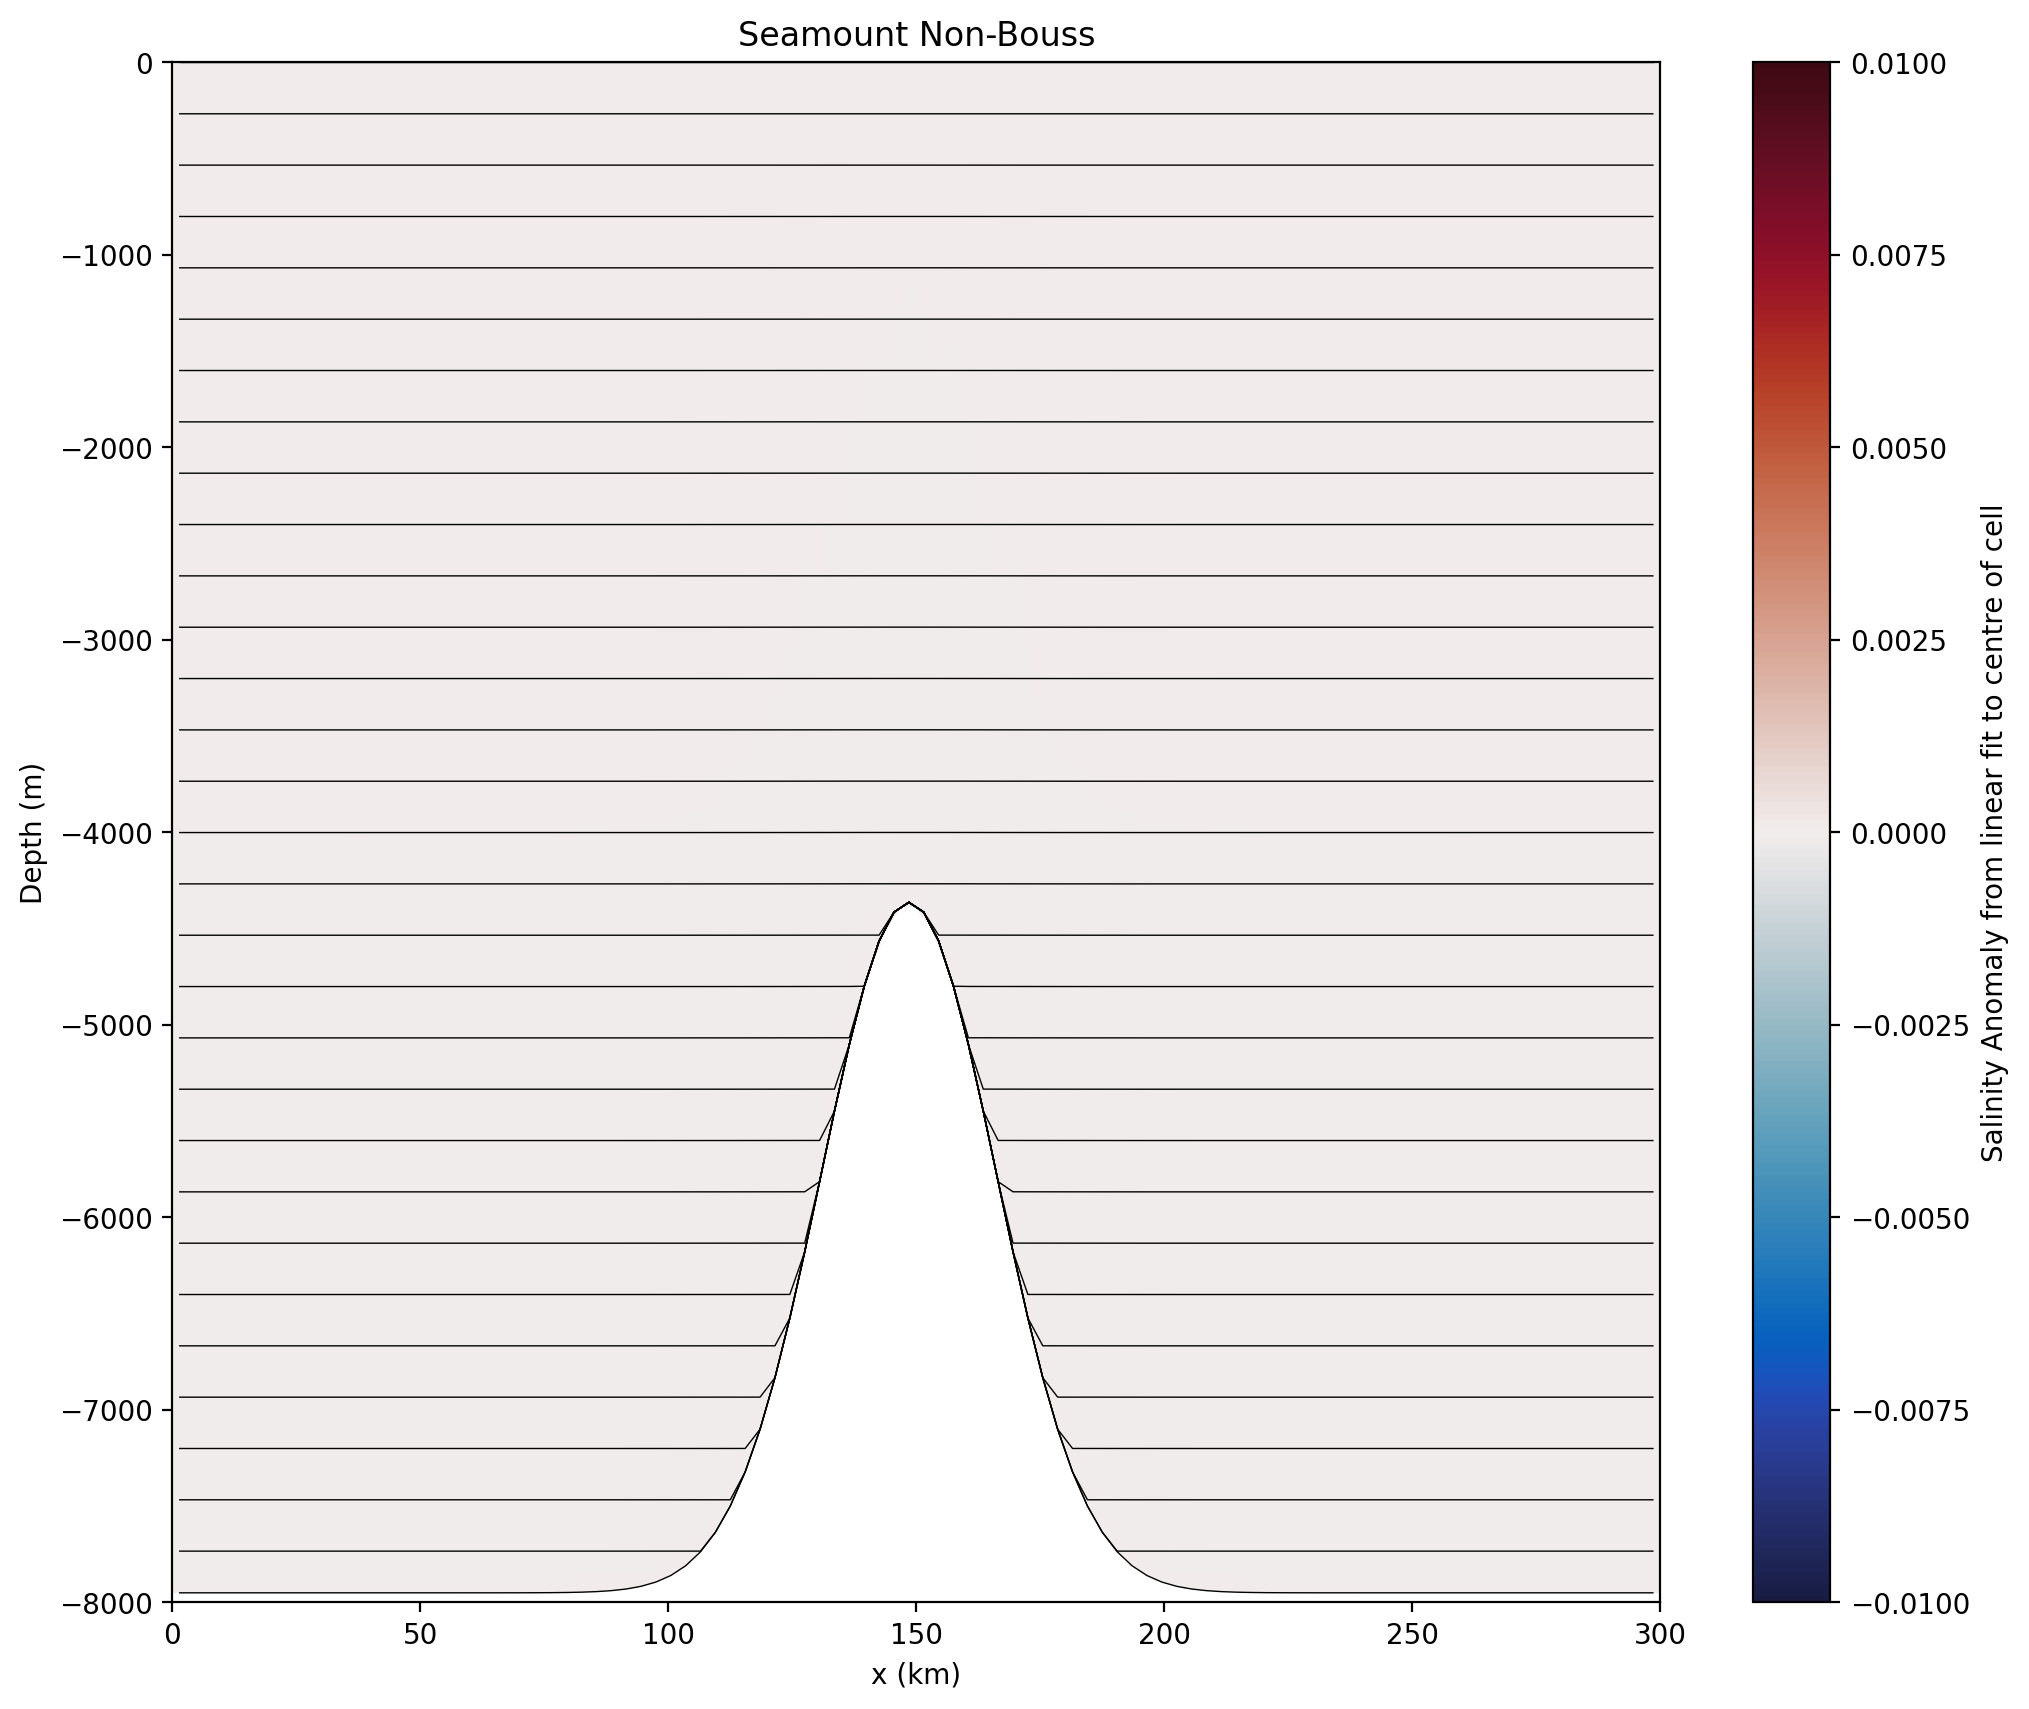

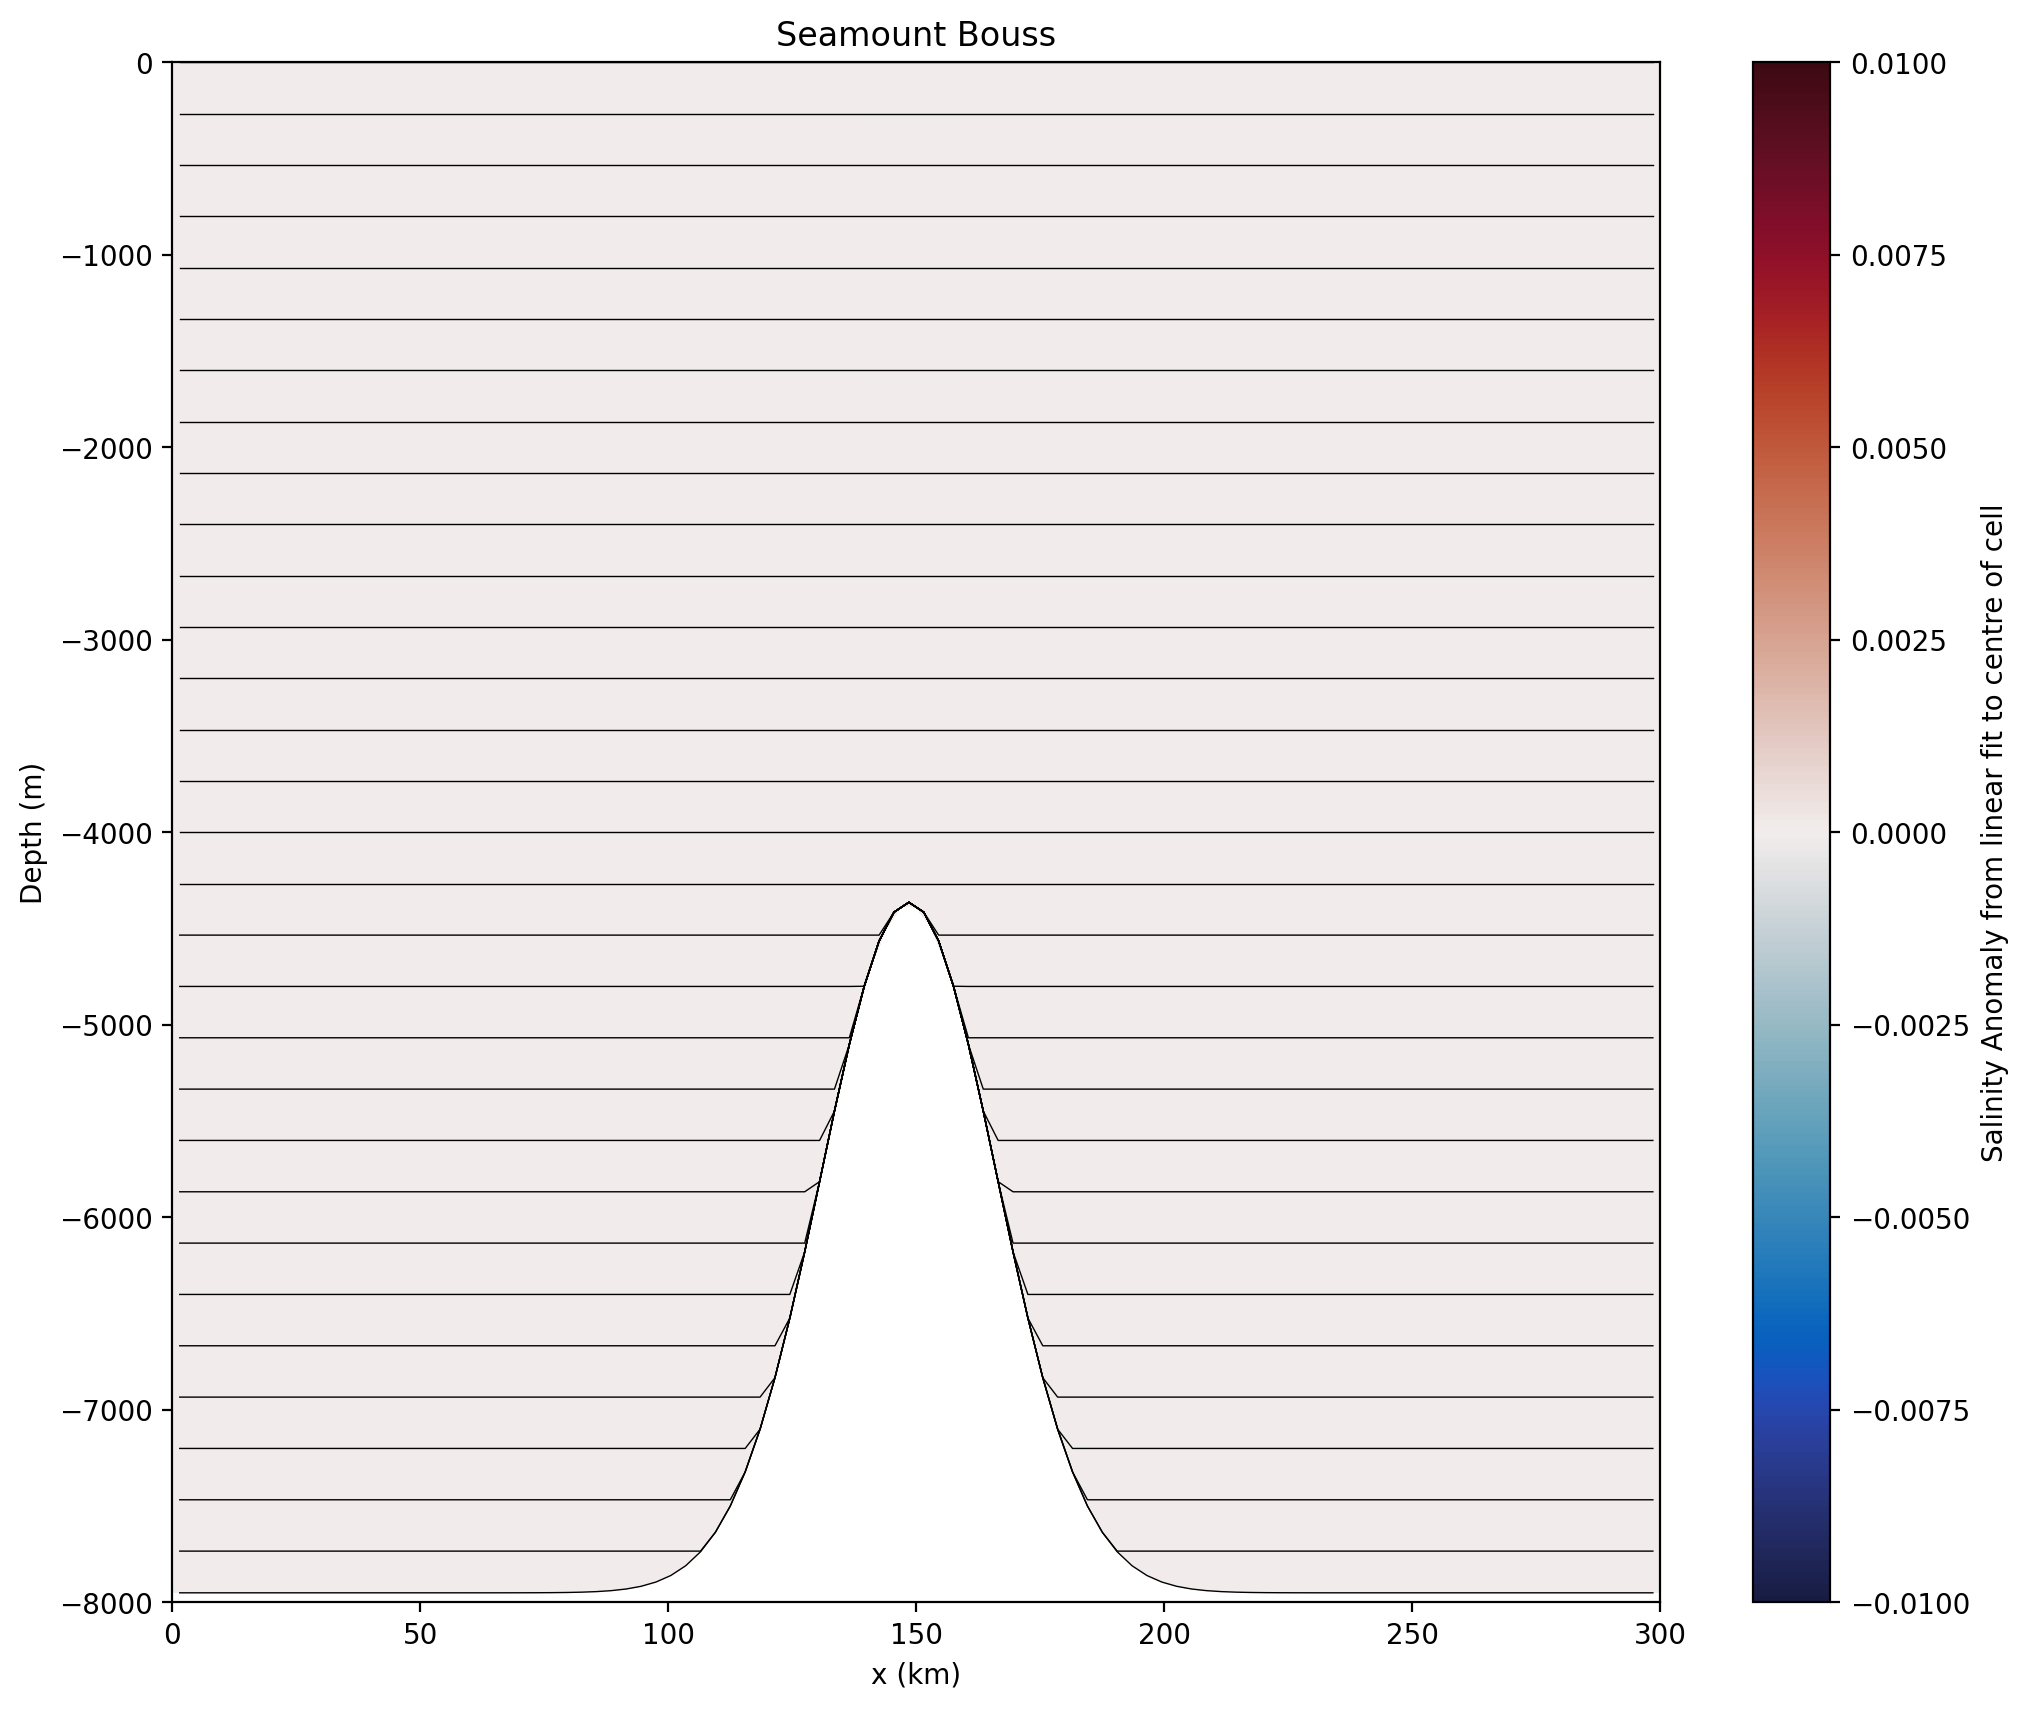

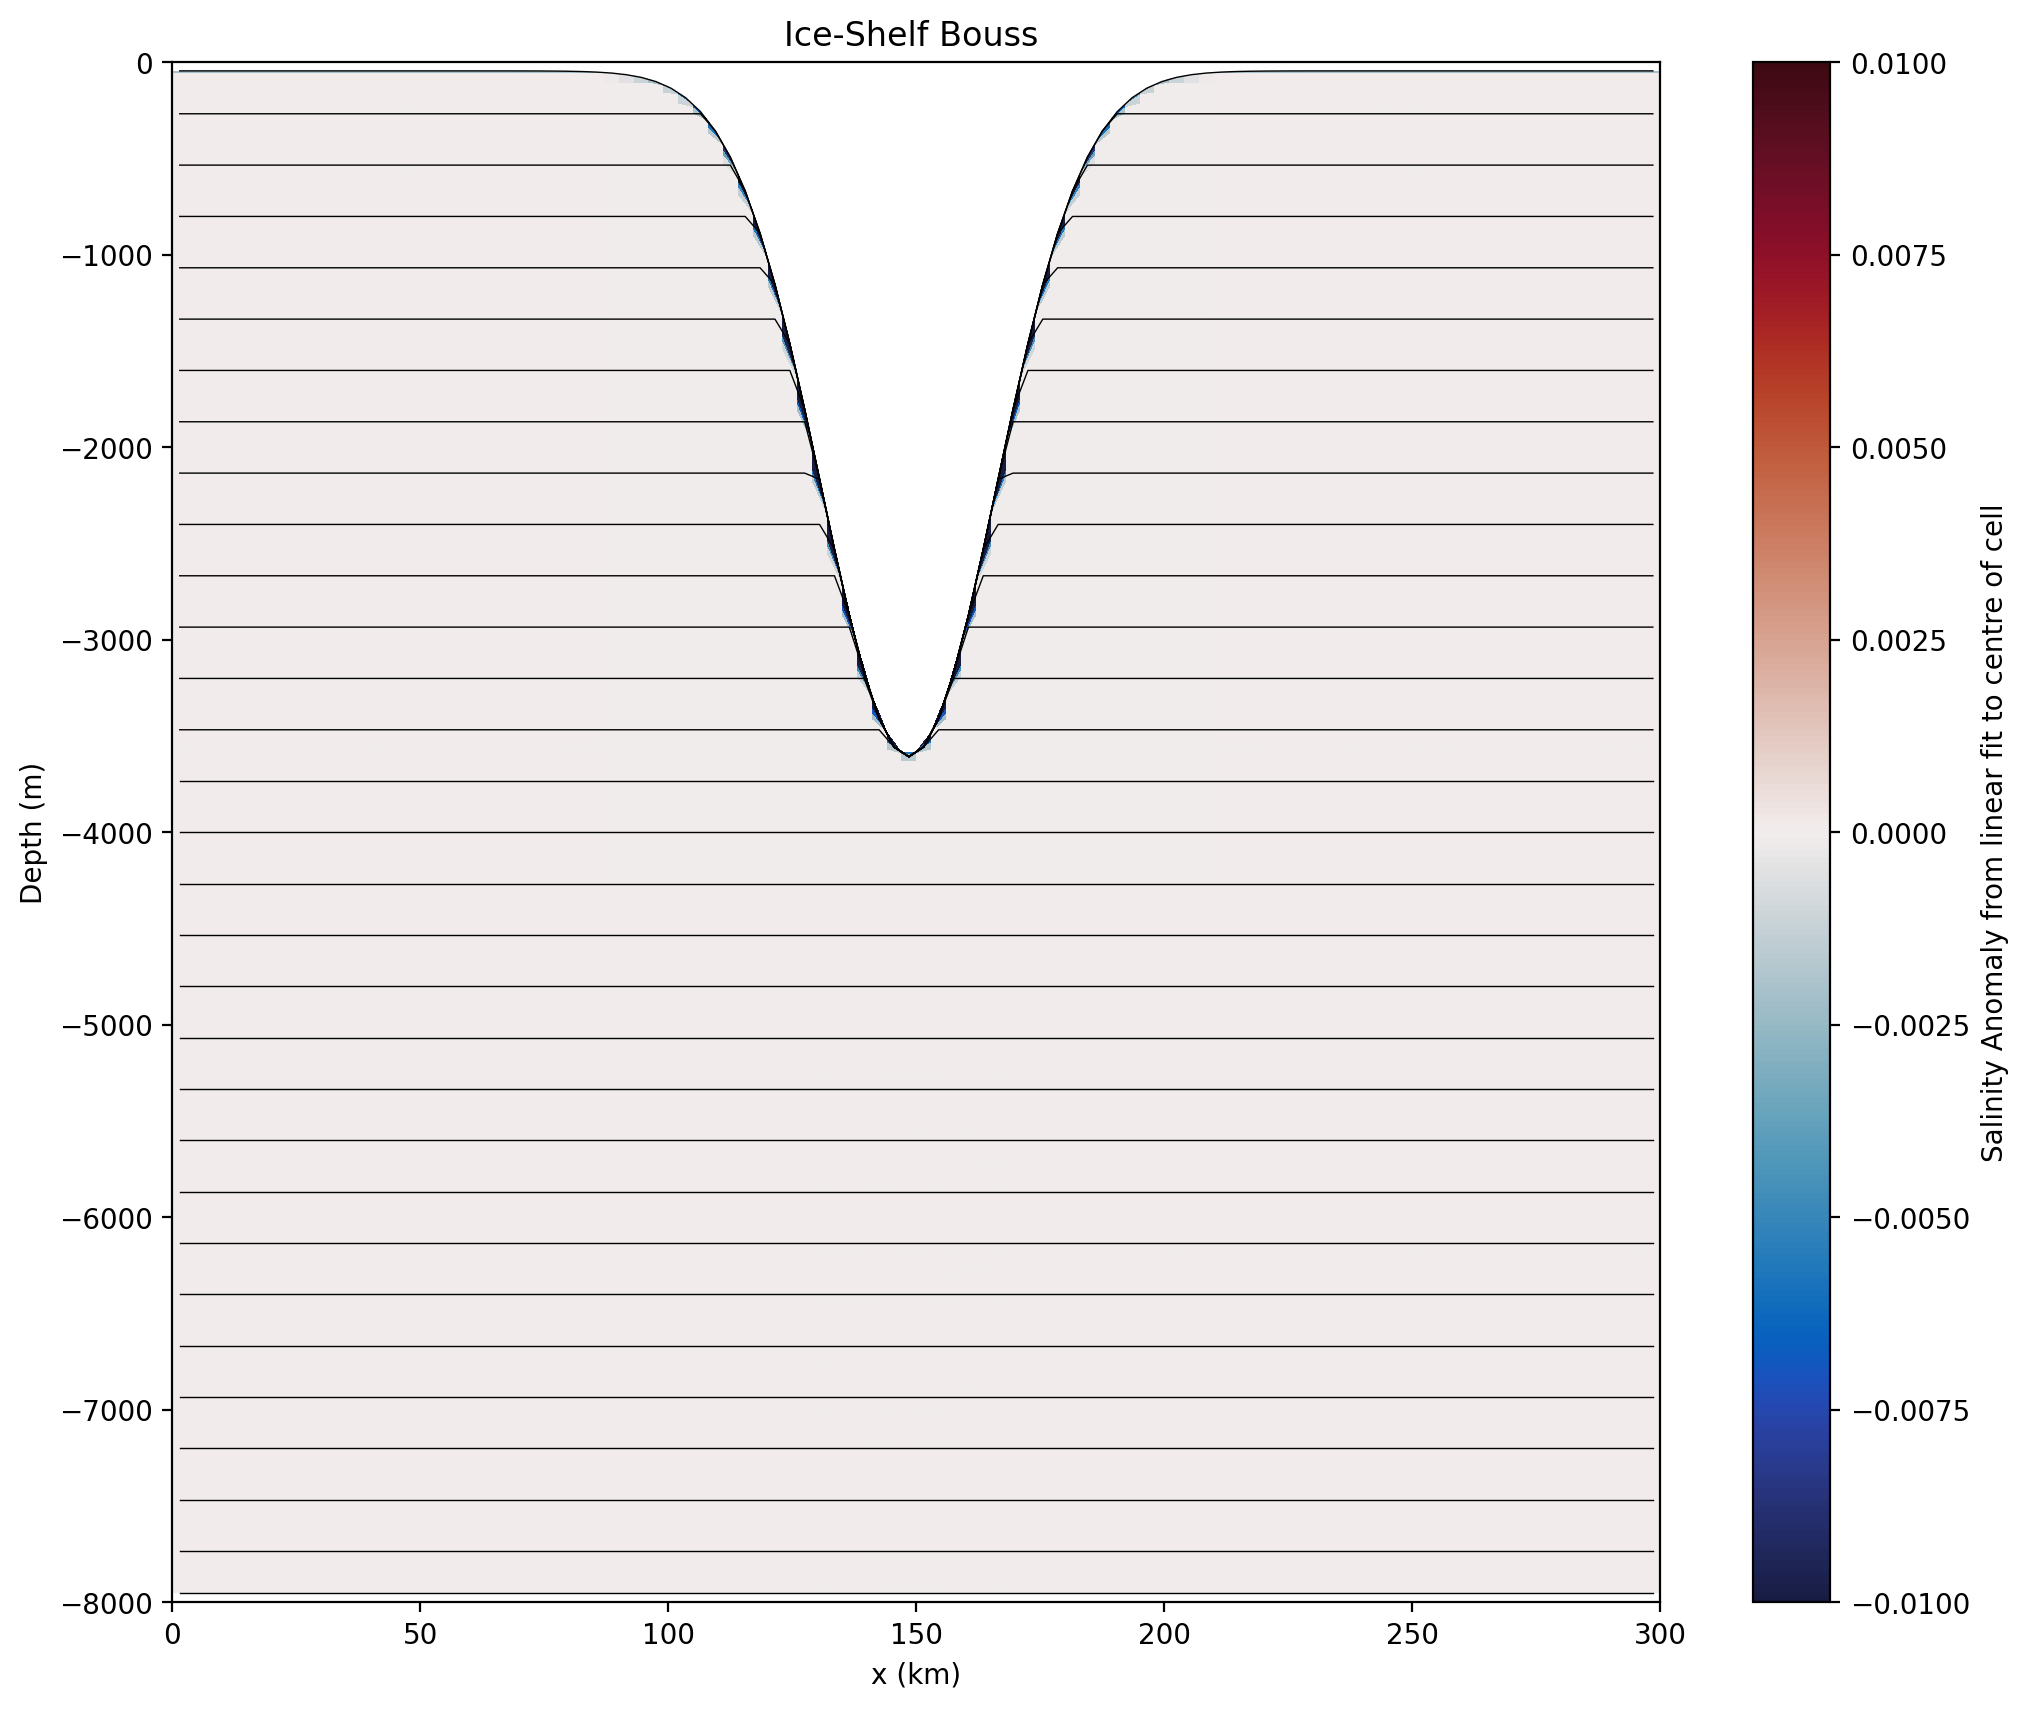

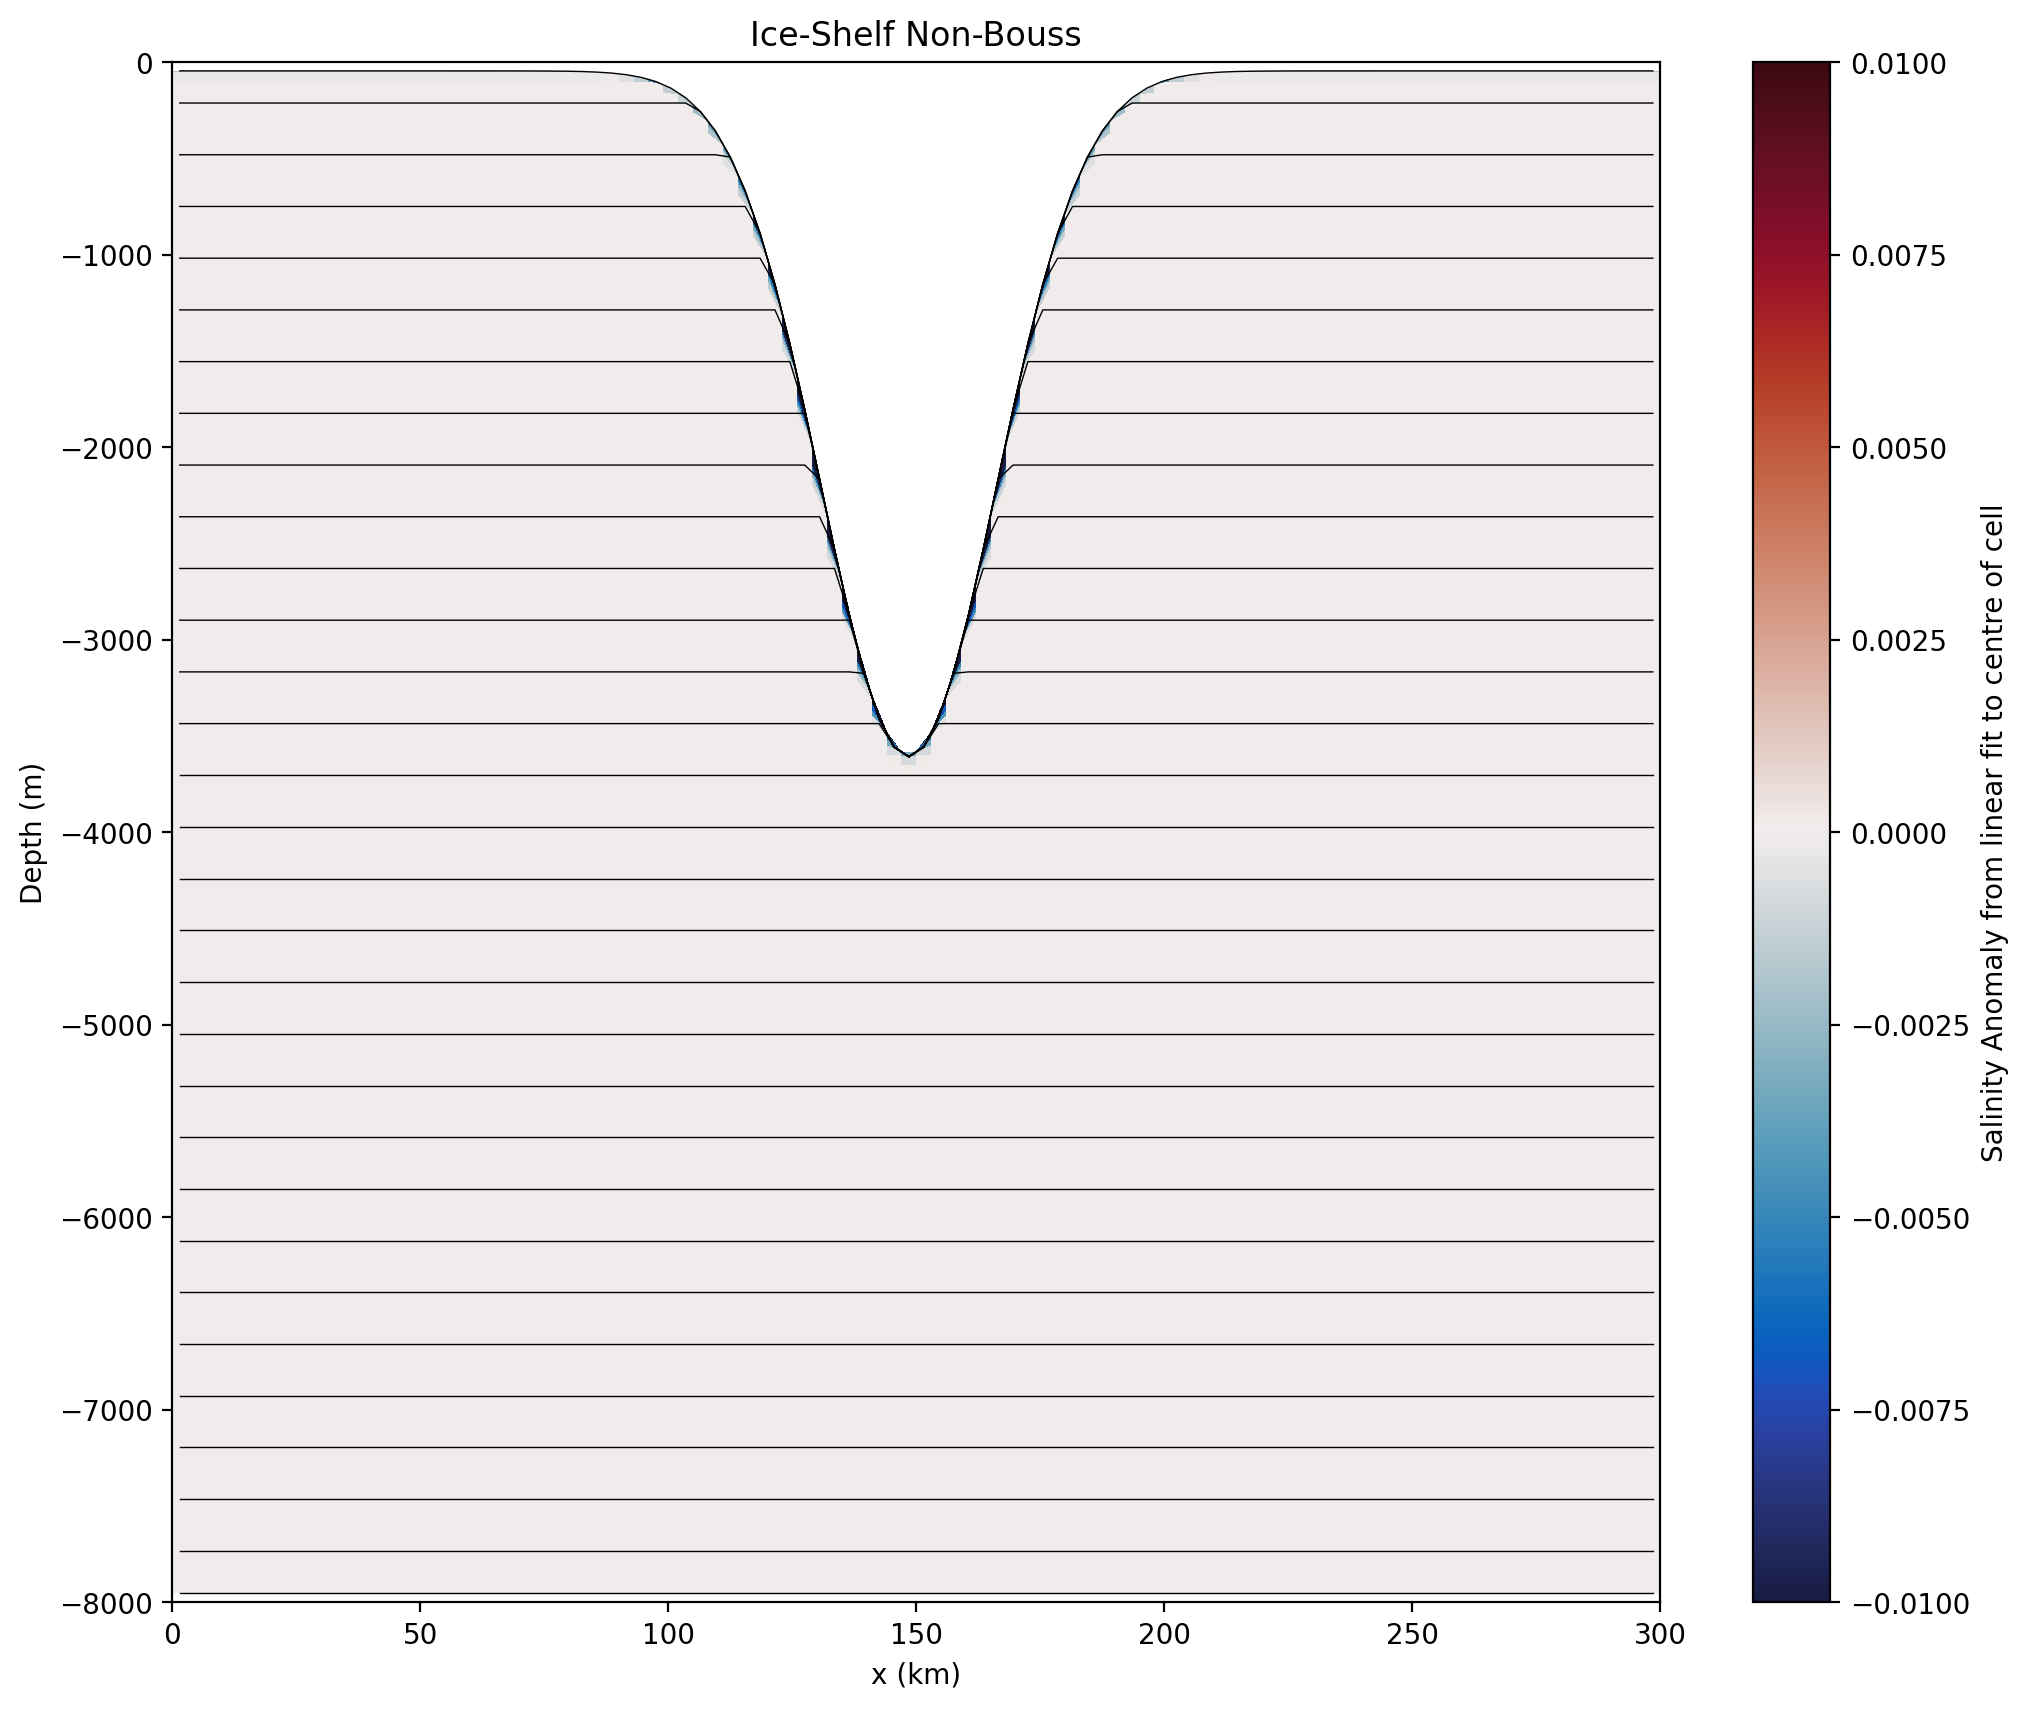

In [20]:
## use IC 
for i in np.arange(20,24):
    label = ['Seamount Non-Bouss','Seamount Bouss','Ice-Shelf Bouss ','Ice-Shelf Non-Bouss'][i-20]
    nonBouss = [True, False, False, True][i-20]
    base = '/home/552/pc5520/MOM6-examples/control/ISOMIP/zco/archive/GPC0'+str(i)+'/output000/'
    folder = base

    fig, ax = plt.subplots(figsize = (12,10), dpi = 200)
    prog, ocean_static = open_files()
    IC = open_IC()
    x = 50
    time = 0
    ymax = 8000
    density = IC.Salt
    # calculate ideal salt from linear fit to centre of cell depth
    if nonBouss:
        # h is then not in units of m, but m*rho
        rho = 999.9106806711001 -0.0383569483*IC.Temp + 0.805876093*IC.Salt
        ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-(IC.h/rho).cumsum('Layer')+IC.h/2/rho)*(34.55-33.8)/(-8000) + 33.8
    else:
        ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-8000) + 33.8
        
    # plot salinity anomaly
    plot(ax,x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-0.01,0.01,cm.cm.balance,ymax)
    plt.title(label)
    plt.show()

*Note:* Only showing every 5th layer line

There is definitely a salinity anomaly still there. However, maybe it doesn't matter much because the generated flow crashes immediately into the seamount and is damped.

Possible cause of salinity anomaly: notice that zstar coordinate for seamount topo case bends upwards, so the salinity is calculated to be slightly less than its neighbour (fresher towards surface of ocean). For ice shelf seamount, zstar coordinate bends slightly down compared to neighbour. If using same algorithm as up, may calculate salinity to be fresher than what linearity suggests -> blue colours? Algorithm seems ok tho:

```
    case (  REGRIDDING_RHO, REGRIDDING_ZSTAR, REGRIDDING_SIGMA_SHELF_ZSTAR, REGRIDDING_SIGMA )
      if (just_read) return ! All run-time parameters have been read, so return.

      dS_dz = (S_sur - S_bot) / G%max_depth
      dT_dz = (T_sur - T_bot) / G%max_depth
      do j=js,je ; do i=is,ie
        xi0 = -depth_tot(i,j)
        do k = nz,1,-1
          xi0 = xi0 + 0.5 * h(i,j,k)     ! Depth in middle of layer
          S(i,j,k) = S_sur + dS_dz * xi0
          T(i,j,k) = T_sur + dT_dz * xi0
          xi0 = xi0 + 0.5 * h(i,j,k)     ! Depth at top of layer
        enddo

```

Some further questions:
- How about this run in `sigma_shelf_zstar` coordinates?
- Why are seamount velocities high? They should be even lower?

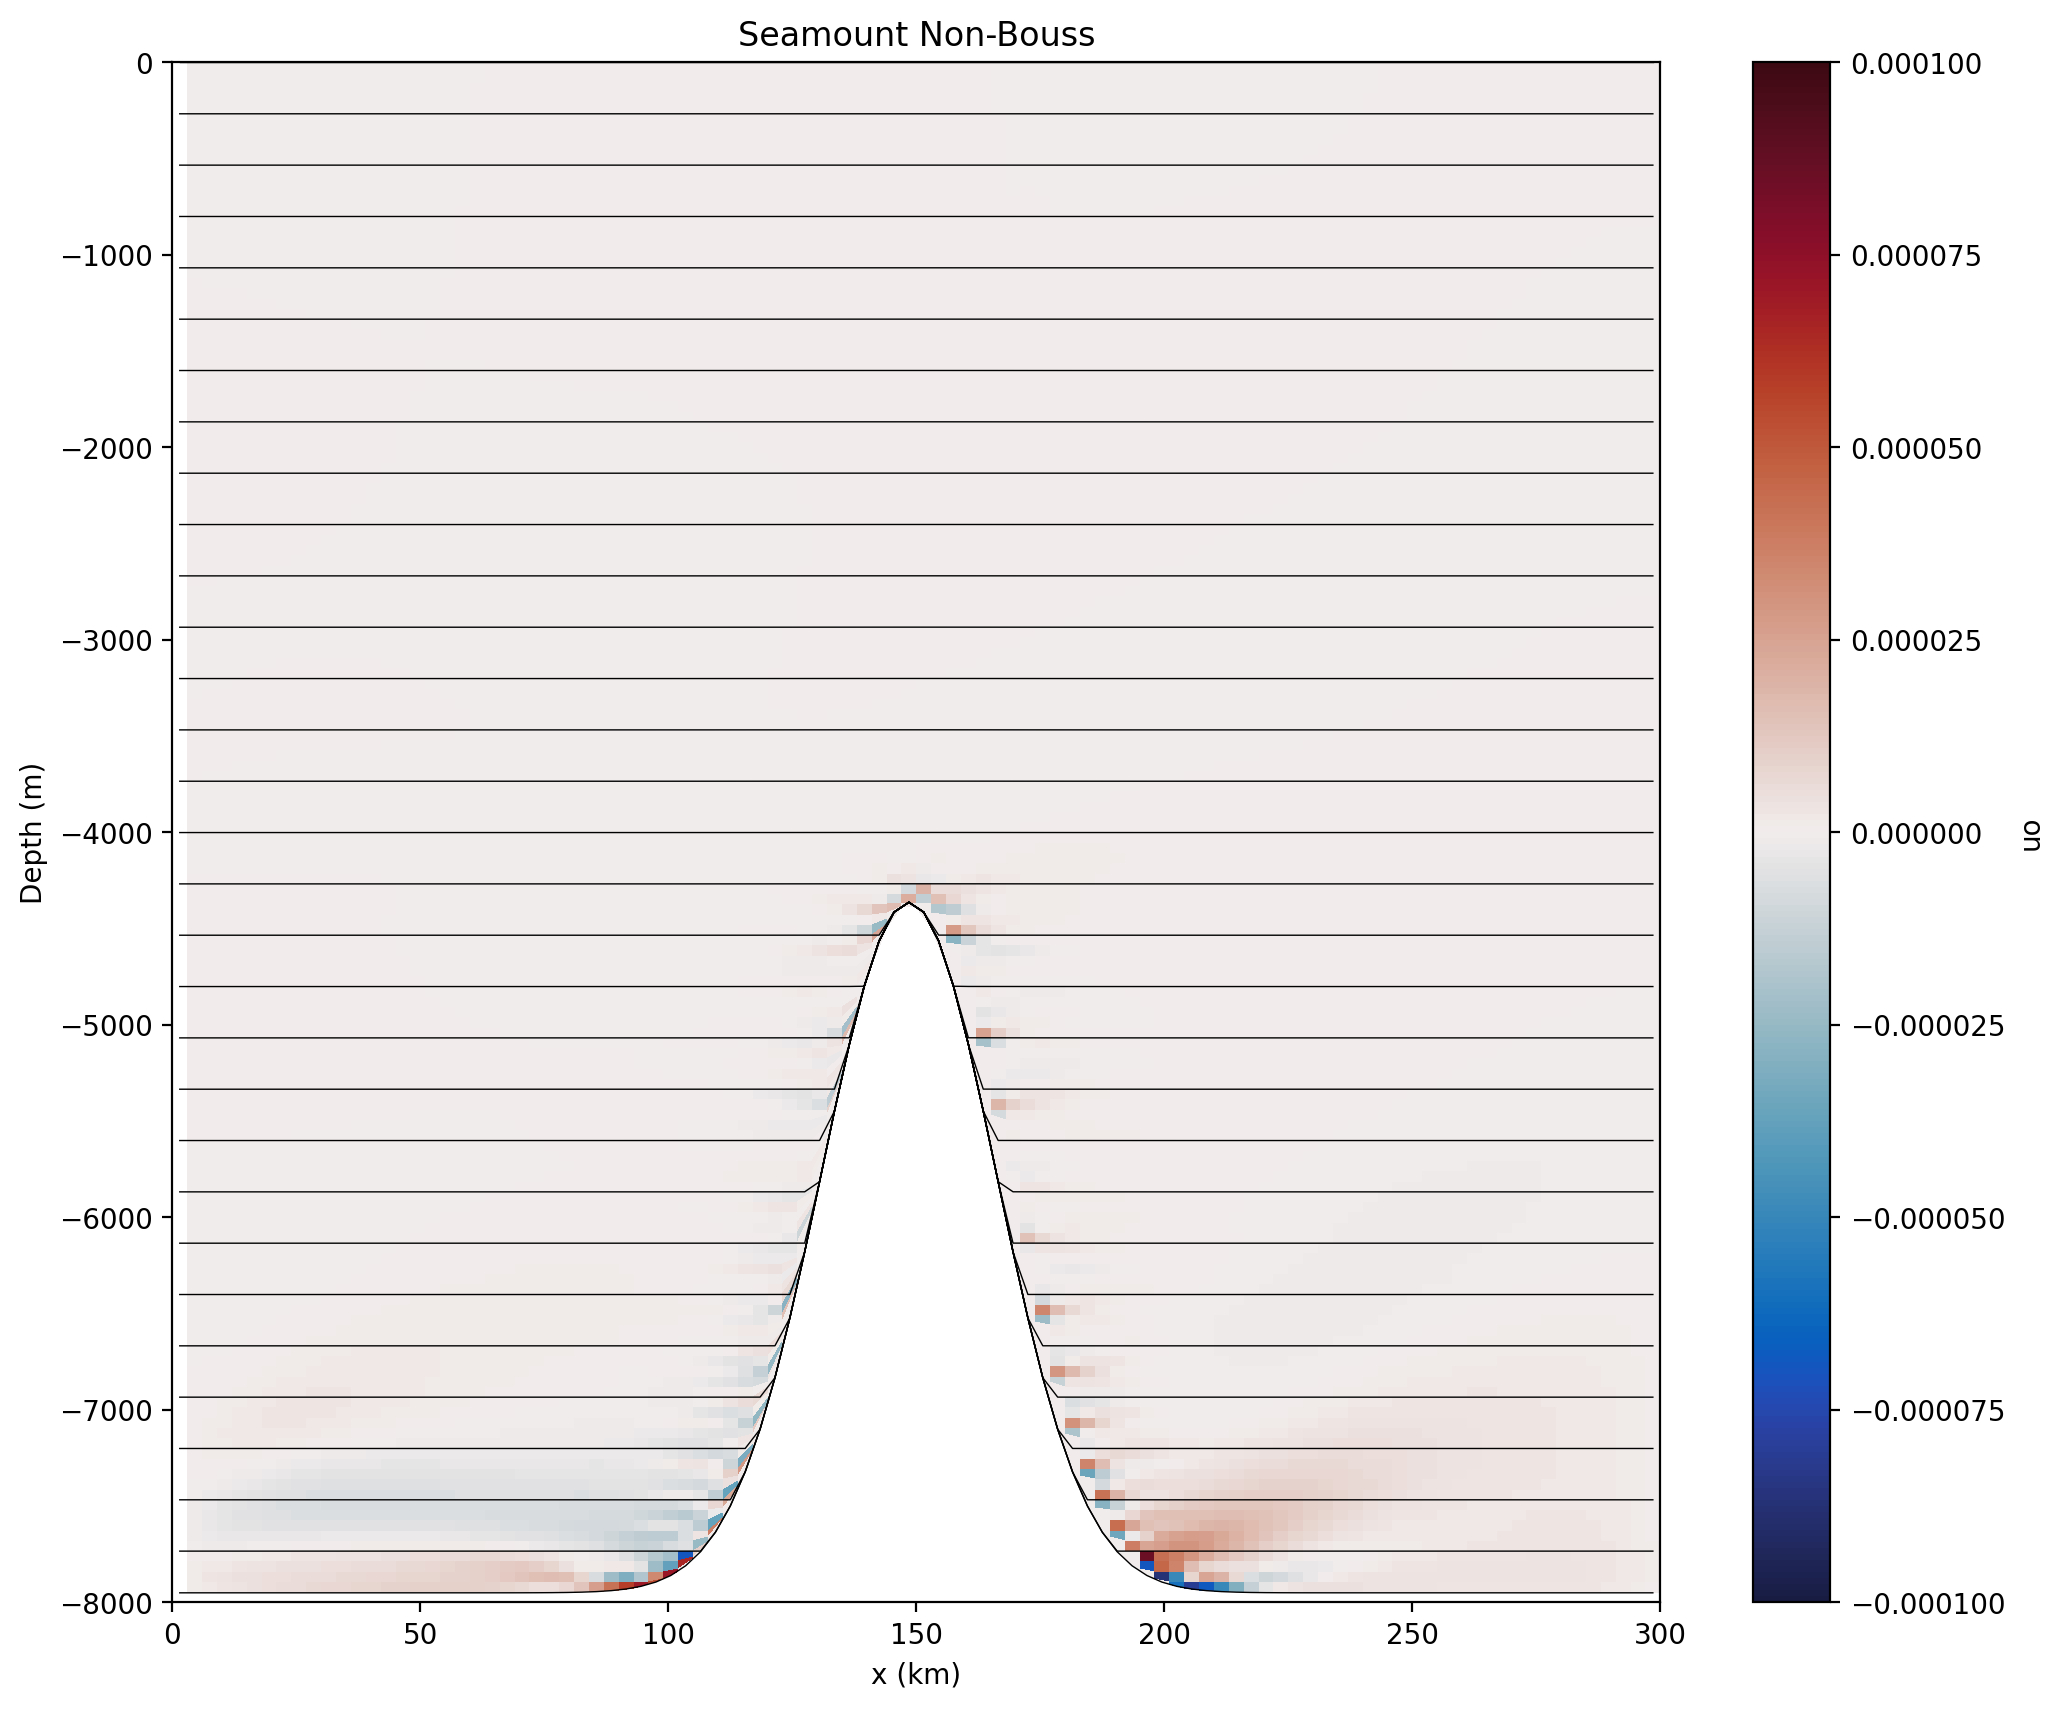

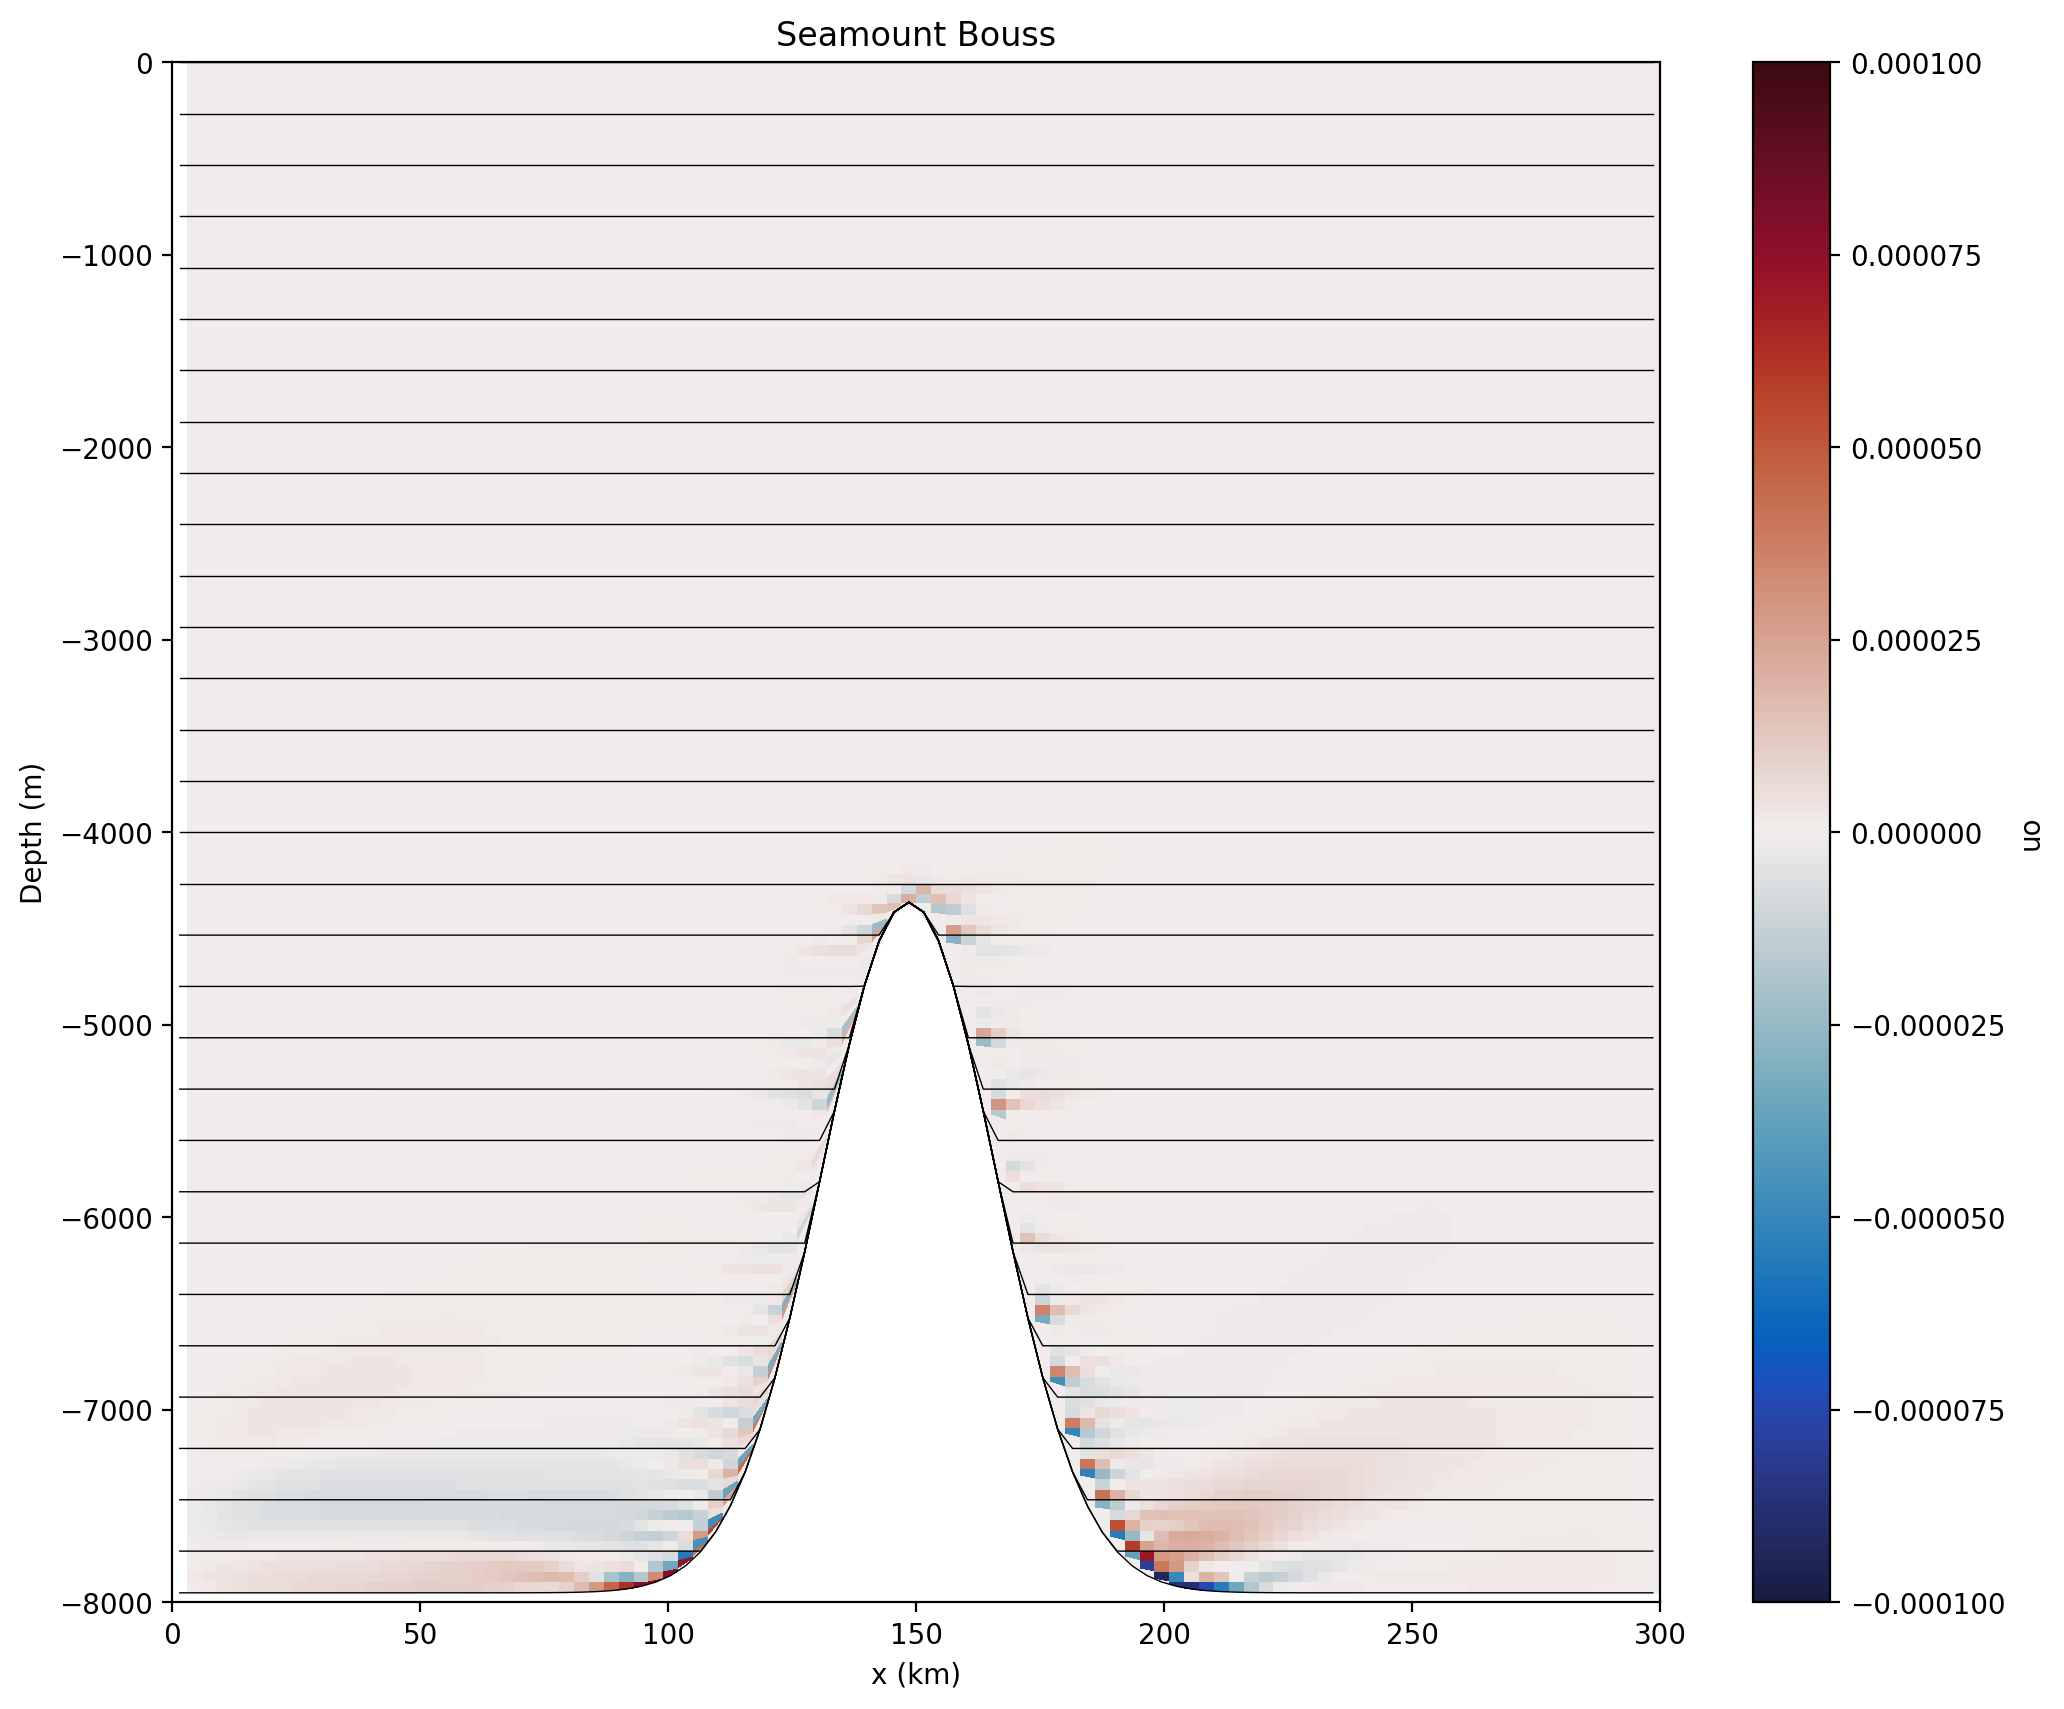

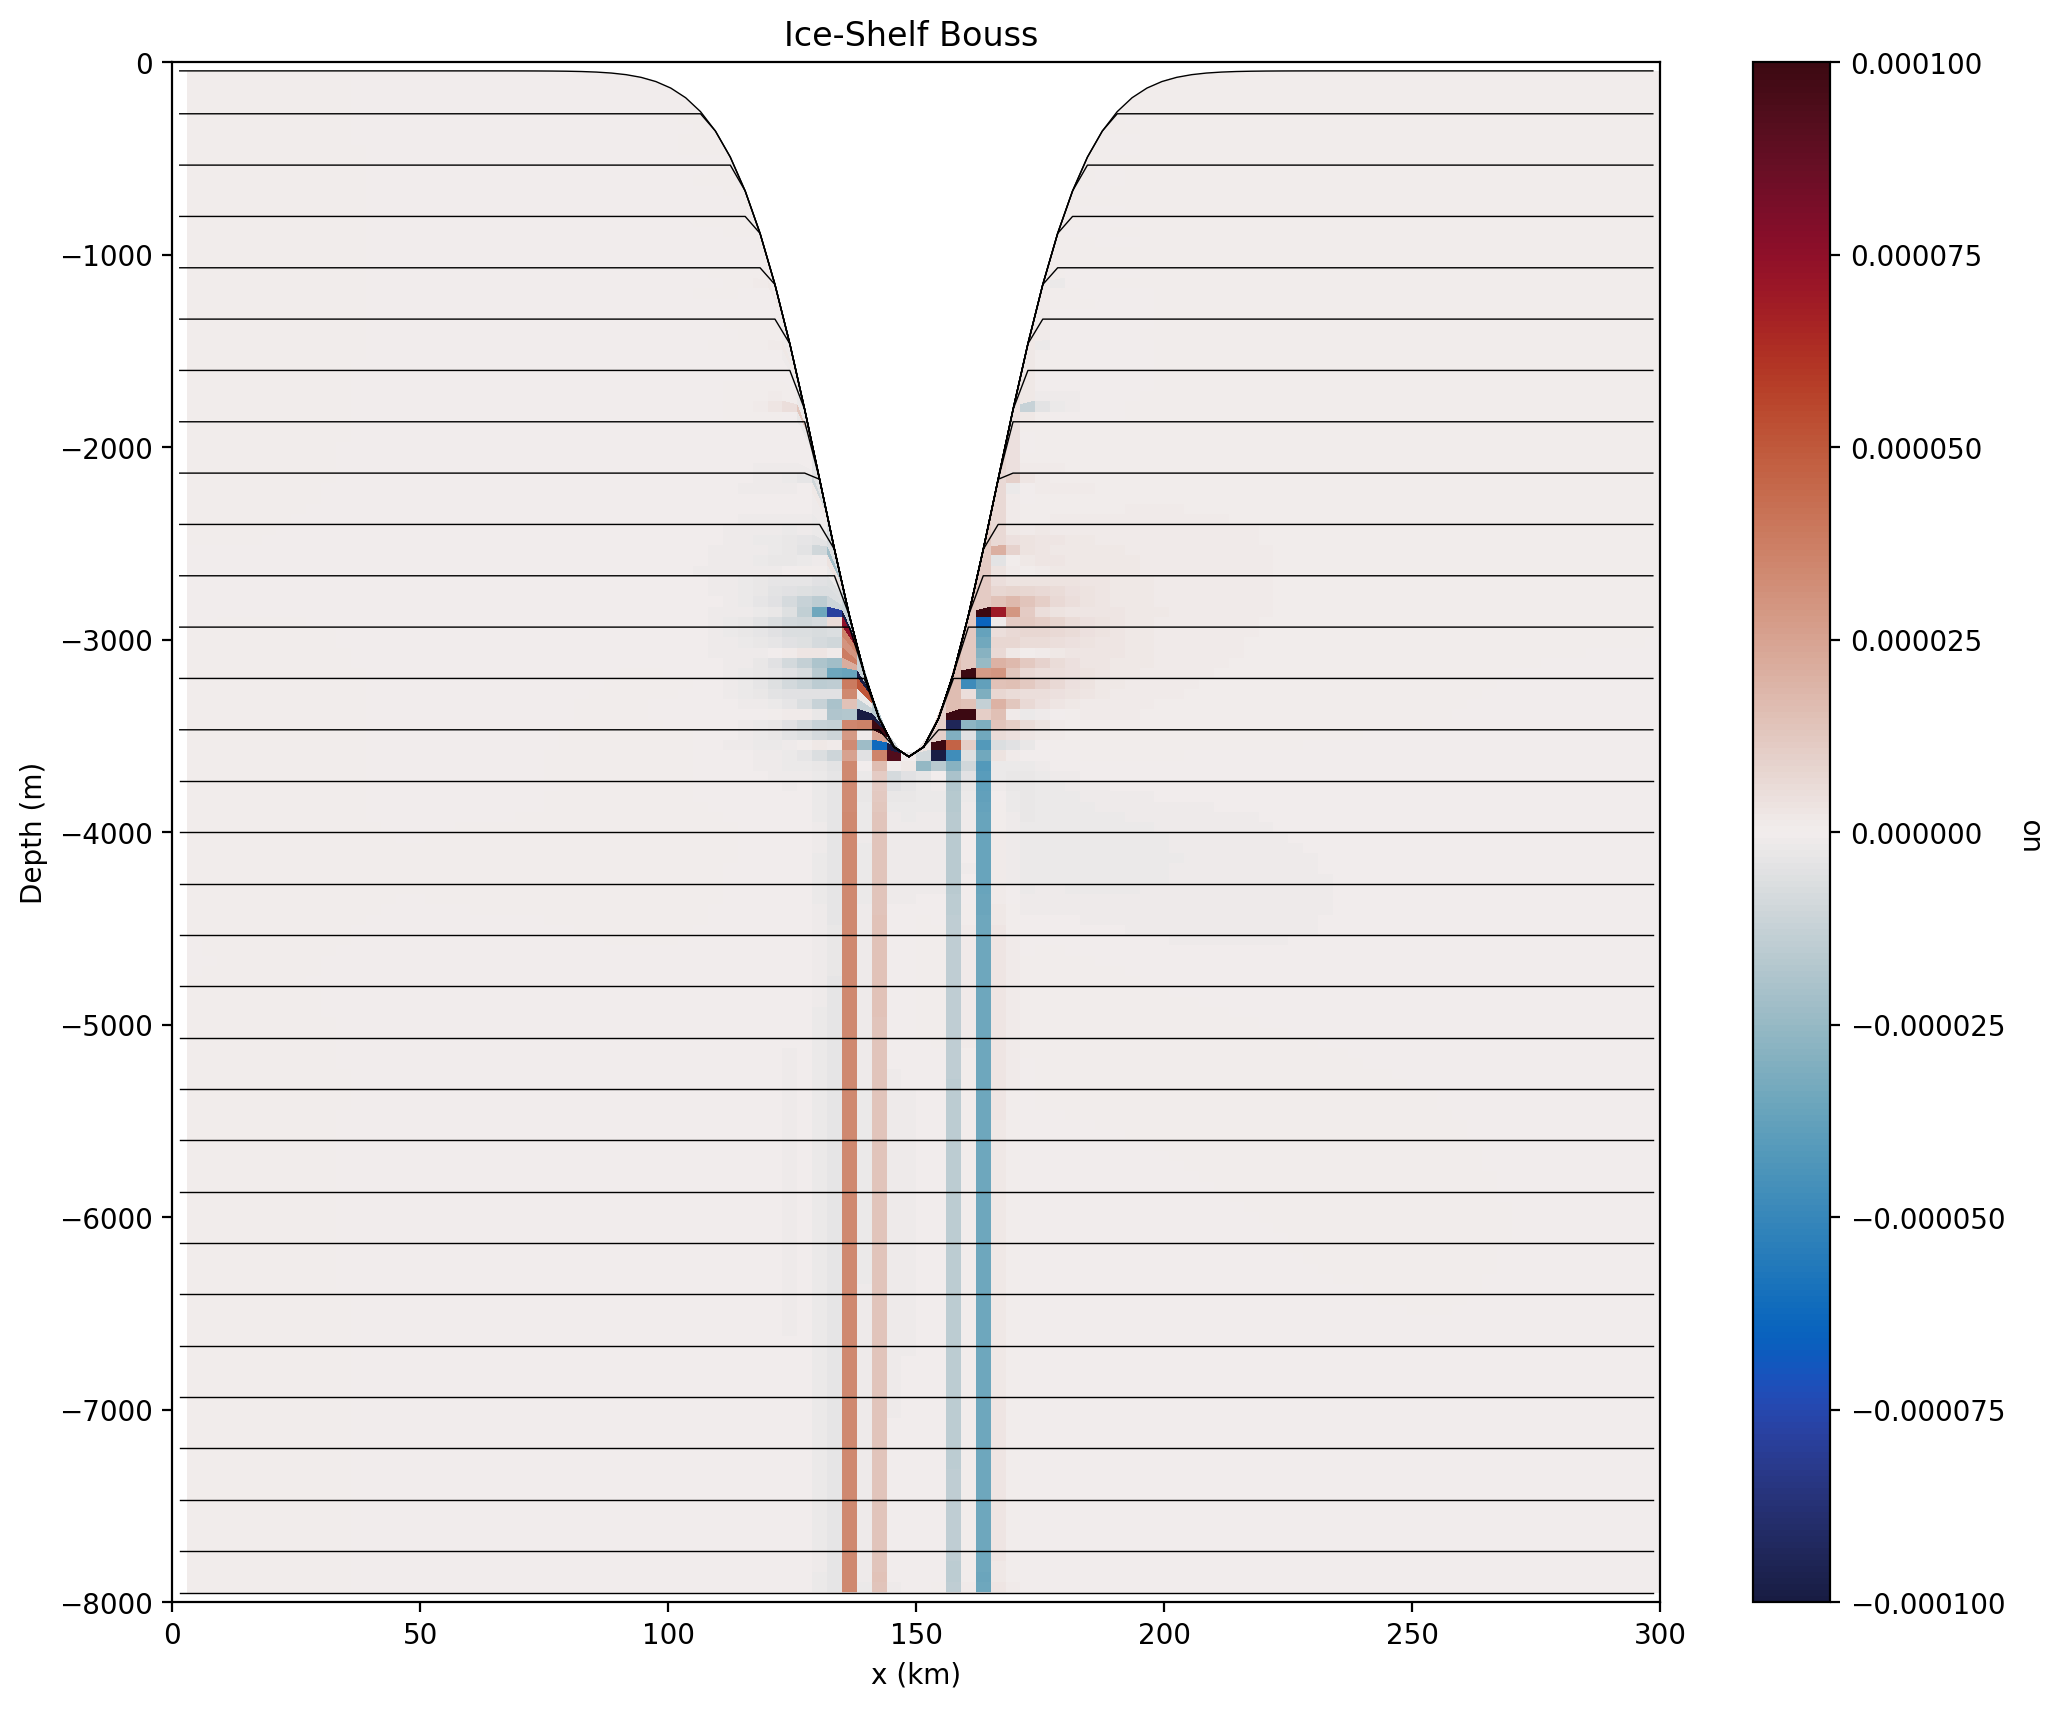

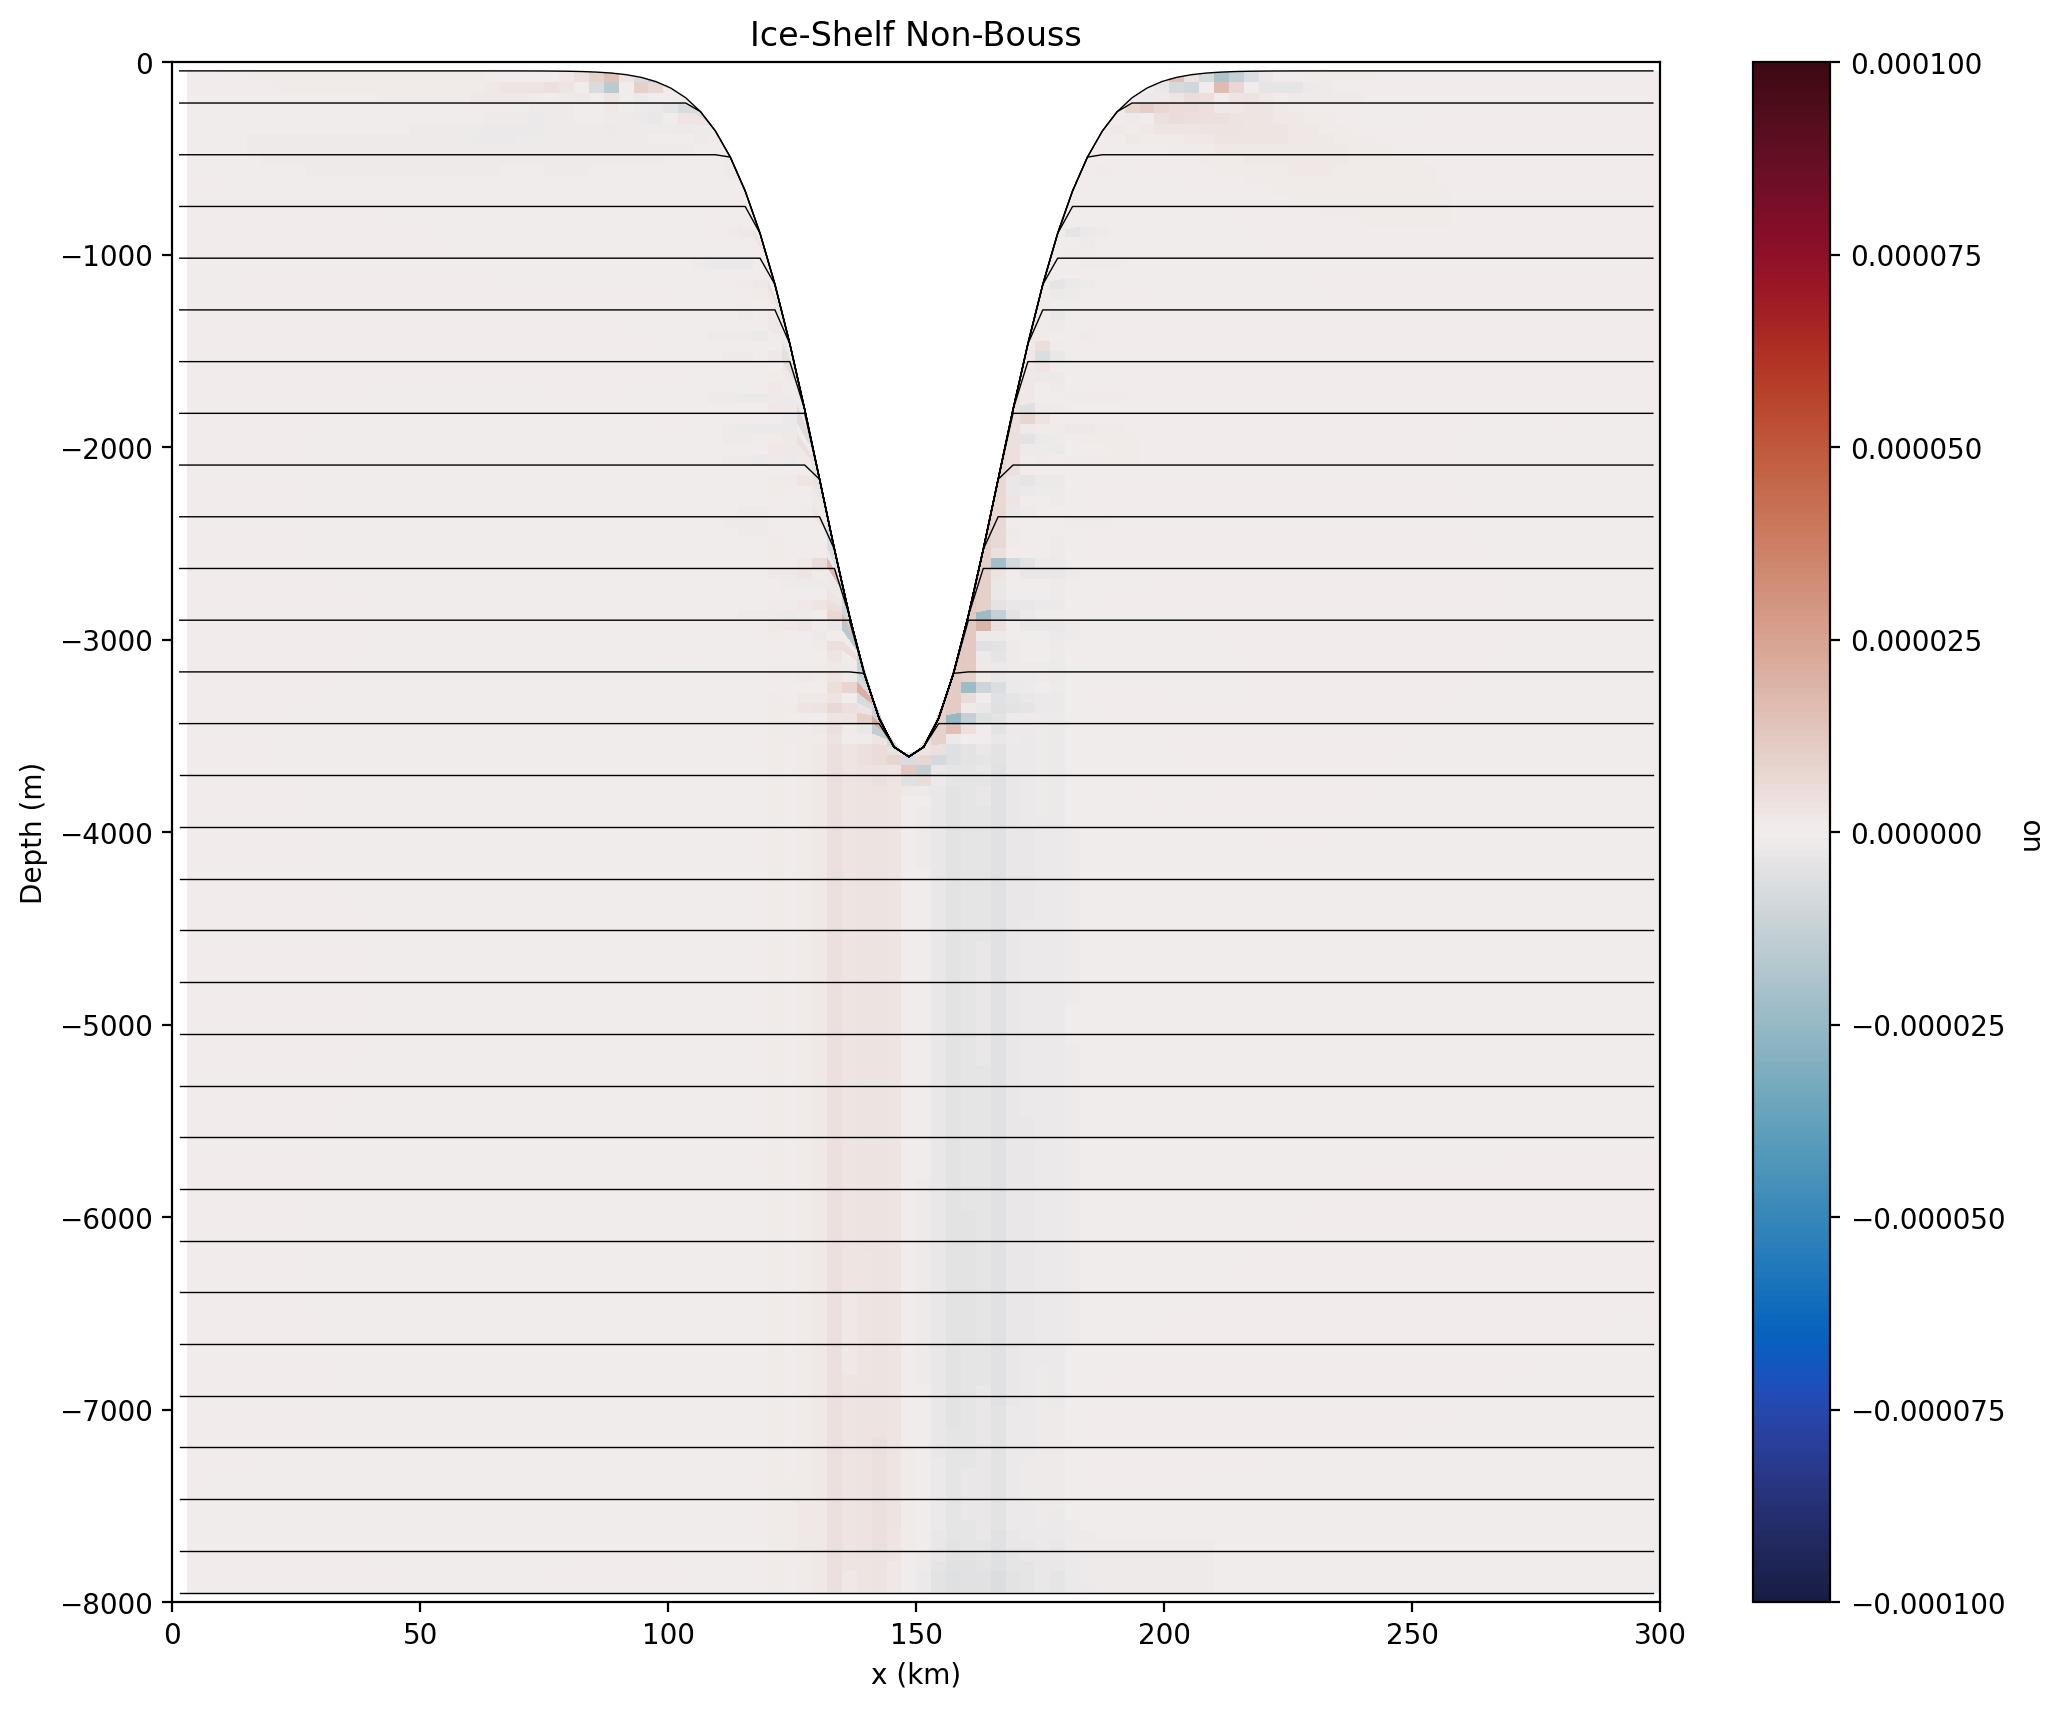

In [23]:
## Plot u
for i in np.arange(20,24):
    label = ['Seamount Non-Bouss','Seamount Bouss','Ice-Shelf Bouss ','Ice-Shelf Non-Bouss'][i-20]
    nonBouss = [True, False, False, True][i-20]
    base = '/home/552/pc5520/MOM6-examples/control/ISOMIP/zco/archive/GPC0'+str(i)+'/output000/'
    folder = base

    fig, ax = plt.subplots(figsize = (12,10), dpi = 200)
    prog, ocean_static = open_files()
    IC = open_IC()
    x = 50
    time = -1
    ymax = 8000
    # plot u
    plot(ax,x,time,0,prog.u,"uo",-0.0001,0.0001,cm.cm.balance,ymax)
    plt.title(label)
    plt.show()